# Project - Grinding Dynamic Simulation Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

In [2]:
def dxdt(t, x, feed, r, b_matrix, d):
    """Ordinary differential equations describing the rate of change of
    mill charge in each size fraction.  This is the 'General Grinding
    Model' described in Molycop Tools spreadsheet (Eq. 3).  Note, t is
    redundant in this case but is included for compatibility with
    numerical solvers which are designed for the general case where dxdt
    can be a function of time also.
    
    Args:
        t (float): Time (mins).
        x (array): Charge load (tons).
        feed (np.ndarray): Mill feed (tons).
        r (array): Breakage rates (selection function).
        b_matrix (array): Breakage matrix (appearance functions).
        d (array): Discharge grate efficiencies.
    """
    return feed + r*(b_matrix - np.diag(d + 1)) @ x

In [3]:
def solve(t, x0, dxdt, timestep_size, args, method='Radau'):
    """Estimates x at time t + timestep by starting at x0 and
    using the derivate function dxdt to numerically solve the
    initial value problem.
    
    Args:
        t: (float): Initial time.
        x0 (array): Initial x at time t (i.e. x[t]). 
        dxdt (function): Function which returns the derivative of x.
        timestep_size (float): Timestep to increment by.
        args (list): Additional arguments to pass to dxdt.
    
    Returns:
        x2 (array): State vector at time t + timestep_size.
    """
    t2 = t + timestep_size
    sol = solve_ivp(dxdt, t_span=[t, t2], y0=x0, method=method,
                    args=args)
    assert sol.status == 0, "Solver failed."

    return sol.y[:, -1]

In [13]:
# Calculation example with 3 size intervals

feed = np.array([ 2,  1,  0]).T

# Discharge grate efficiencies
d = np.array([  0, 0.5, 1.0]).T

# Breakage rates
r = np.array([0.2, 0.4, 0.1]).T

# Initial charge
x0 = np.array([30, 30, 30])

# Breakage matrix
b_matrix = np.array([
    [  0,   0,   0],
    [0.5,   0,   0],
    [0.5, 1.0,   0]
])

t = 0
timestep_size = 0.5
solve(t, x0, dxdt, timestep_size, args=[feed, r, b_matrix, d])

array([28.09674836, 23.90858247, 33.61877618])

In [57]:
# Simulate over time (with constant feed)
nt = 50
x = np.zeros((nt, 3))
feed_rates = np.repeat(feed.reshape(1,-1), nt, axis=0)
discharge_rates = np.zeros((nt, 3))
x[0] = x0
t = np.arange(nt) * timestep_size
for k in range(1, nt):
    feed = feed_rates[k]
    x[k, :] = solve(t[k], x[k-1], dxdt, timestep_size, args=[feed, r, b_matrix, d])
    discharge_rates[k] = feed + x[k-1] - x[k]

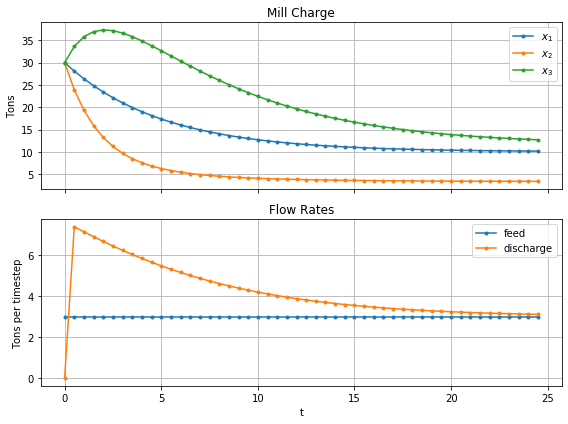

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)

ax = axes[0]
for i in range(3):
    ax.plot(t, x[:,i], '.-', label=f'$x_{i+1}$')
ax.set_title('Mill Charge')
ax.set_ylabel('Tons')
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(t, feed_rates.sum(axis=1), '.-', label='feed')
ax.plot(t, discharge_rates.sum(axis=1), '.-', label='discharge')
ax.set_title('Flow Rates')
ax.set_xlabel('t')
ax.set_ylabel('Tons per timestep')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()